# Poker hand classification
This notebook looks to build a machine learning model that can accuractely classify a poker hand given 5 cards. Basically a model for poker hand rule induction.

Although this is absolutely something that is better suited to a standard logic based classification ruleset, e.g. if two of the same number then its a pair, I am interested to see how the model performs. 

The data comes from the Kaggle `Poker Hand Classification` dataset, found at https://www.kaggle.com/dysphoria/poker-hand-classification?select=poker-hand-training.data

<br/>

#### Features
10 Attributes describing cards. \
1 label describing poker hand value (this is what we want to predict). \

The 5 cards of the hand are set out in the following attribute format:
* Suit of card #n, where 1-4 indicates {Hearts, Spades, Diamond, Clubs}
* Number of card #n, where 1-13 indicates {Ace, 2, 3, ..., Queen, King}

<br/>
 
The poker hand value refers to the following list: 
* 0: nothing in hand; not a recognized poker hand
* 1: one pair; one pair of equal ranks within five cards
* 2: two pairs; two pairs of equal ranks within five cards
* 3: three of a kind; three equal ranks within five cards
* 4: straight; five cards, sequentially ranked with no gaps
* 5: flush; five cards with the same suit
* 6: full house; pair + different rank three of a kind
* 7: four of a kind; four equal ranks within five cards
* 8: straight flush; straight + flush
* 9: royal flush; {Ace, King, Queen, Jack, Ten} + flush 


In [5]:
# Import all the tools we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For better displayinfing of our data structures
import json

# Models from SCikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [7]:
# load data
df = pd.read_csv('./data/poker-hand-training.csv')
# where S1 = the suit of card1, and C1 = the card value of card1
df.columns = ["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5", "Hand"]
df.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand
0,2,11,2,13,2,10,2,12,2,1,9
1,3,12,3,11,3,13,3,10,3,1,9
2,4,10,4,11,4,1,4,13,4,12,9
3,4,1,4,13,4,12,4,11,4,10,9
4,1,2,1,4,1,5,1,3,1,6,8


## Data Exploration

In [4]:
# investigate basic data structure
print(df.shape)
print(df.info());
# Check if there are missing values
df.isna().sum()  # There are no missing values

(25009, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25009 entries, 0 to 25008
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   S1      25009 non-null  int64
 1   C1      25009 non-null  int64
 2   S2      25009 non-null  int64
 3   C2      25009 non-null  int64
 4   S3      25009 non-null  int64
 5   C3      25009 non-null  int64
 6   S4      25009 non-null  int64
 7   C4      25009 non-null  int64
 8   S5      25009 non-null  int64
 9   C5      25009 non-null  int64
 10  Hand    25009 non-null  int64
dtypes: int64(11)
memory usage: 2.1 MB
None


S1      0
C1      0
S2      0
C2      0
S3      0
C3      0
S4      0
C4      0
S5      0
C5      0
Hand    0
dtype: int64

In [24]:
df.describe()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand
count,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000
mean,2.508817,6.995122,2.497781,7.014035,2.510296,7.013915,2.495981,6.942261,2.497381,6.962973,0.620817
std,1.116465,3.749832,1.121750,3.766965,1.123130,3.744858,1.115991,3.747086,1.118715,3.741463,0.786594
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,4.000000,1.000000,4.000000,2.000000,4.000000,1.000000,4.000000,1.000000,4.000000,0.000000
50%,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,1.000000
75%,4.000000,10.000000,4.000000,10.000000,4.000000,10.000000,3.000000,10.000000,3.000000,10.000000,1.000000
max,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,9.000000


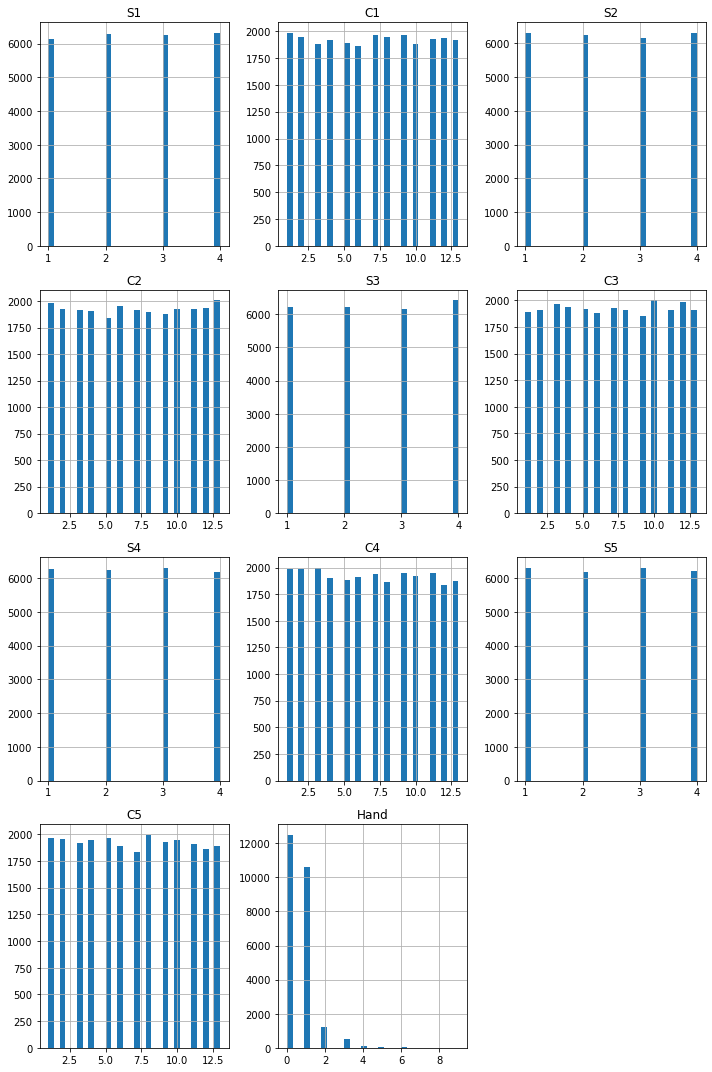

In [54]:
df.hist(bins=30, figsize=(10,15));
plt.tight_layout()
plt.show()

In [14]:
df.mode()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand
0,4,1,1,13,4,10,3,3,3,8,0


0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        4
Name: Hand, dtype: int64


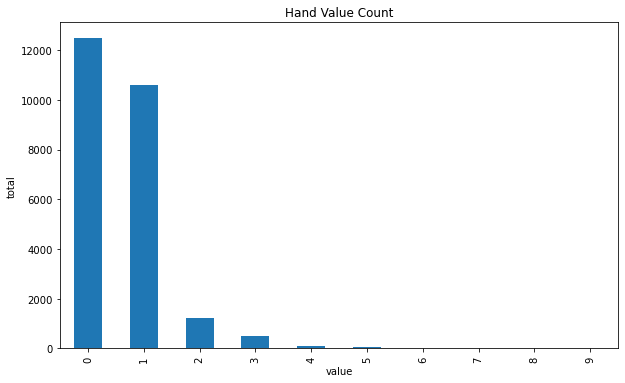

In [35]:
print(df["Hand"].value_counts())
df["Hand"].value_counts().plot(kind="bar", figsize=(10, 6));

plt.title("Hand Value Count")
plt.xlabel("value")
plt.ylabel("total");

The findings:
* We can see that the values are realtively even spread, with the means of the first 10 columns sitting around what we expect (2.5 for suit and 7 for number). 
* We have a count of 25009, and there are no missing values in that count
* A hand of 0 – nothing in hand – is by far the most common hand. Where if the model just predicted 0 every time, it'd get around a 50% accuracy score (12493/25009 empty hands).


In [36]:
df.corr()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand
S1,1.000000,-0.010277,-0.021337,0.008295,-0.019692,-0.009861,-0.017374,0.003897,-0.024241,0.006540,0.008838
C1,-0.010277,1.000000,0.004503,-0.011027,-0.000339,-0.026338,0.004104,-0.014483,0.004896,-0.016917,0.001976
S2,-0.021337,0.004503,1.000000,-0.002382,-0.029380,-0.005219,-0.021033,0.012099,-0.011914,0.005697,-0.000569
C2,0.008295,-0.011027,-0.002382,1.000000,-0.005294,-0.024771,-0.008333,-0.012991,0.000697,-0.016317,-0.005653
S3,-0.019692,-0.000339,-0.029380,-0.005294,1.000000,0.018030,-0.013071,0.001947,-0.030380,-0.002107,0.004533
C3,-0.009861,-0.026338,-0.005219,-0.024771,0.018030,1.000000,-0.003106,-0.016411,0.003817,-0.010842,-0.006951
S4,-0.017374,0.004104,-0.021033,-0.008333,-0.013071,-0.003106,1.000000,-0.008623,-0.018273,0.005260,-0.000984
C4,0.003897,-0.014483,0.012099,-0.012991,0.001947,-0.016411,-0.008623,1.000000,0.002883,-0.014596,0.009612
S5,-0.024241,0.004896,-0.011914,0.000697,-0.030380,0.003817,-0.018273,0.002883,1.000000,-0.003243,-0.005059
C5,0.006540,-0.016917,0.005697,-0.016317,-0.002107,-0.010842,0.005260,-0.014596,-0.003243,1.000000,-0.001741


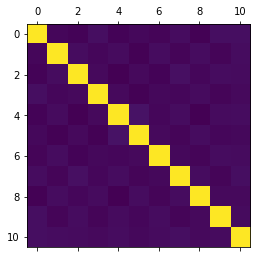

In [37]:
plt.matshow(df.corr())
plt.show()

As we'd expect, there isn't much of a correlation between the values, as we're dealing with a essentially random dataset.

## Modelling

In [112]:
# Prepare data
X = df.drop("Hand", axis=1)
y = df["Hand"]

# Split data into train and test sets
np.random.seed(7)
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=7)

In [49]:
np.random.seed(42)
model = RandomForestClassifier().fit(X_train, y_train)
model.score(X_test, y_test)

0.6019592163134746

In [6]:
from sklearn.svm import SVC

## NOTE: these are other poptential classifier models that could've been used
# from sklearn.neural_network import MLPClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Linear-SVC": SVC(kernel="linear", C=0.025),
#           "SVC": SVC(gamma=2, C=1),
#           "Gaussian Process Classifier": GaussianProcessClassifier(1.0 * RBF(1.0), verbose=2),
#           "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=5, verbose=2),
         }

# Create a function that both fits and scores our models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and scores ML models.
    models: a dict of Sklearn models
    X_train: training data
    X_test: test data
    y_train: labels for training data
    y_test: labels for test data
    """
    
    np.random.seed(7)
    # Set up empty dict for our model scores
    model_scores = {}
    fitted_models = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
        fitted_models.append(model)
        
    return [model_scores, fitted_models]

In [7]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test);


/Users/jacob/Documents/Post-Bootcamp/ml-projects/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
model_scores[0]

{'Logistic Regression': 0.49020391843262695,
 'KNN': 0.5515793682526989,
 'Random Forest': 0.6095561775289884,
 'Linear-SVC': 0.49020391843262695}

Out of the models tested, `RandomForest` seems to be the fastest.

### HyperParameter tuning using RandomizedSearchCV

In [11]:
# RandomForestClassifier hyperparameter grid 
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [12]:
np.random.seed(7)
rand_forest_rs = RandomizedSearchCV(RandomForestClassifier(),
                                    param_distributions=rf_grid,
                                    cv=5, 
                                    n_iter=15,
                                    verbose=True)

rand_forest_rs.fit(X_train, y_train)

print("Our best parameters are:")
rand_forest_rs.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/jacob/Documents/Post-Bootcamp/ml-projects/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  5.9min finished


Our best parameters are:


{'n_estimators': 860,
 'min_samples_split': 18,
 'min_samples_leaf': 5,
 'max_depth': None}

In [13]:
print(f"After hyperparameter tuning our model got a score of {rand_forest_rs.score(X_test, y_test)}")
print(f"The model however scored higher accuracy with the default values.")

# Since the model with default values scored the highest, thats the one we'll save
import pickle
clf = RandomForestClassifier().fit(X_train, y_train)
pickle.dump(clf, open("./models/pokerhand_rf_clf1.pkl", "wb"))

After hyperparameter tuning our model got a score of 0.6033586565373851
The model however scored higher accuracy with the default values.


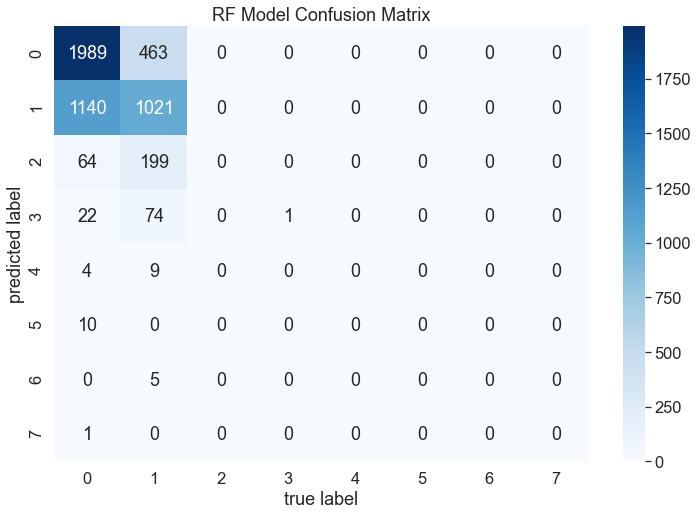

In [56]:
# Evaluating our model beyond accuracy
np.random.seed(42)
clf = RandomForestClassifier().fit(X_train, y_train)

y_preds = clf.predict(X_test)

# Create confusion matrix using seaborn
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                      annot=True, # Annotate the boxes
                      cmap='Blues', 
                      fmt='g'
                     )
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    plt.title("RF Model Confusion Matrix")
    
plot_conf_mat(y_test, y_preds)


In [83]:
print('The value counts of y_test/y_true is as follows:')
print(y_test.value_counts())
print()
print('The value counts of y_pred is as follows:')
print(pd.DataFrame(y_preds).value_counts())

[[1989  463    0    0    0    0    0    0]
 [1140 1021    0    0    0    0    0    0]
 [  64  199    0    0    0    0    0    0]
 [  22   74    0    1    0    0    0    0]
 [   4    9    0    0    0    0    0    0]
 [  10    0    0    0    0    0    0    0]
 [   0    5    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0]]

The value counts of y_test/y_true is as follows:
0    2452
1    2161
2     263
3      97
4      13
5      10
6       5
9       1
Name: Hand, dtype: int64

The value counts of y_pred is as follows:
0    3230
1    1771
3       1
dtype: int64


Note that, the poker hand value refers to the following list:

    * 0: nothing in hand; not a recognized poker hand
    * 1: one pair; one pair of equal ranks within five cards
    * 2: two pairs; two pairs of equal ranks within five cards
    * 3: three of a kind; three equal ranks within five cards
    * 4: straight; five cards, sequentially ranked with no gaps
    * 5: flush; five cards with the same suit
    * 6: full house; pair + different rank three of a kind
    * 7: four of a kind; four equal ranks within five cards
    * 8: straight flush; straight + flush
    * 9: royal flush; {Ace, King, Queen, Jack, Ten} + flush


In [78]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.62      0.81      0.70      2452
           1       0.58      0.47      0.52      2161
           2       0.00      0.00      0.00       263
           3       1.00      0.01      0.02        97
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         1

    accuracy                           0.60      5002
   macro avg       0.27      0.16      0.15      5002
weighted avg       0.57      0.60      0.57      5002



#### Cross-validation Evaluation Metrics

In [113]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

clf = RandomForestClassifier()
# Find the weighted averages of the below cross_validated evaluation metrics
scoring = {'accuracy_score': 'accuracy', 
           'prec_weighted': make_scorer(precision_score, average="weighted", zero_division=0),
           'recall_weighted': make_scorer(recall_score, average="weighted"),
           'f1_weighted': make_scorer(f1_score, average="weighted")}

scores = cross_validate(clf, X, y, cv=5, scoring=scoring);
averages = { k:sum(scores[k]) / len(scores[k]) for k in scores}

print("The cross-validated evaluation metrics of our model are as follows: \n  ")
print('\n'.join(f'{metric}: {averages[metric]}' for metric in averages.keys()))

/Users/jacob/Documents/Post-Bootcamp/ml-projects/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


The cross-validated evaluation metrics of our model are as follows: 
  
fit_time: 2.0573363304138184
score_time: 0.1425342559814453
test_accuracy_score: 0.6043422023312249
test_prec_weighted: 0.563981902234207
test_recall_weighted: 0.6043422023312249
test_f1_weighted: 0.5721627050548106


#### Findings
From the evaluation above we can see that our model:
* only predicted three categories, i.e. no hand, one pair, and three of the kind (in one instance).
* When the value was 0/no-hand, the value had a high recall score, meaning it predicted most of the true values in this category, and a relatively high precision.
    * Note that, a random guess would get around 50 % accuracy in this category. 
* It predicted around 50% of the values of category 1, indicating thast it had inferred some kind of rules about the pair relationship.
* It predcietd practically nothing in the other categories other than one true positive in the 3 of a kind category, suggesting with more data it could perhaps shave a better chance at working out that rule. 

### Feature Importances and discussion

In [33]:
clf = pickle.load(open("./models/pokerhand_rf_clf1.pkl", "rb"))
feature_importances = clf.feature_importances_
feature_importances

array([0.06512813, 0.1329009 , 0.06843345, 0.13098043, 0.06934337,
       0.13204192, 0.06586401, 0.13654064, 0.06450998, 0.13425717])

In [79]:
feature_importance_dict = dict(zip(df.columns, list(clf.feature_importances_)))
feature_importance_averages = {
    "suit_average_importance": np.mean(feature_importances[::2]),
    "card_average_importance": np.mean(feature_importances[1::2])
}

print(json.dumps(feature_importance_dict, indent=4))
print('\n'.join(f'{feature}: {feature_importance_averages[feature]}' for feature in feature_importance_averages.keys()))


{
    "S1": 0.06639017033027608,
    "C1": 0.13397662256201476,
    "S2": 0.06967575835732533,
    "C2": 0.13442604778890196,
    "S3": 0.06924358654616534,
    "C3": 0.1286396239327723,
    "S4": 0.06520236271545393,
    "C4": 0.1302873408767769,
    "S5": 0.06748016628363201,
    "C5": 0.13467832060668125
}
suit_average_importance: 0.06665578926838307
card_average_importance: 0.13334421073161695


It seems that the model is giving more importance to the card number rather than suit (around 2.5x more), most likely because there are far more common hands that rely on them.

### Final thoughts
Our model is getting around 60% accuracy predicting many of the 0 and 1 hands. This is not much better than choosing at random (~50% accuracy). 

This may be able to improved by:
* Getting more data
* Restructuing the data, so that the realtionship between suit and card is better established
* Minimising the scope of what we're trying to predict / dropping data that seems to be irrelevant (noisy) to the model, for example those hands with less than 1% outcomes
* Trying different classifier models.